In [1]:
# load dependencies'
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' surpresses warnings at spatial distribution
pd.set_option('display.max_columns', None) # pandas show all columns of table instead of restricted#
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import numpy as np
import math
import plotly.express as px
import sklearn.linear_model
import sklearn.neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt


import sklearn.impute



from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig#, Inspection
# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

from eda_quality import correction as correct
from eda_quality import manipulation as manipulate
from eda_quality import inspection as inspect


In [2]:
bbox = BboxSelector([
    7.554130554199218, # min_x
    51.95590322041212, # min_y
    7.590351104736328, # max_x
    51.97874790276371  # max_y
])

track_df = track_api.get_tracks(bbox=bbox, num_results=40) 
correct.drop_dublicates(track_df)

Deleted rows:  186


,id,time,geometry,Engine Load.value,Engine Load.unit,Calculated MAF.value,Calculated MAF.unit,Speed.value,Speed.unit,CO2.value,CO2.unit,Intake Pressure.value,Intake Pressure.unit,Rpm.value,Rpm.unit,Intake Temperature.value,Intake Temperature.unit,Consumption (GPS-based).value,Consumption (GPS-based).unit,GPS Altitude.value,GPS Altitude.unit,Throttle Position.value,Throttle Position.unit,GPS Bearing.value,GPS Bearing.unit,Consumption.value,Consumption.unit,GPS Accuracy.value,GPS Accuracy.unit,CO2 Emission (GPS-based).value,CO2 Emission (GPS-based).unit,GPS Speed.value,GPS Speed.unit,track.id,track.length,track.begin,track.end,sensor.type,sensor.engineDisplacement,sensor.model,sensor.id,sensor.fuelType,sensor.constructionYear,sensor.manufacturer,track.appVersion,track.touVersion,GPS HDOP.value,GPS HDOP.unit,GPS PDOP.value,GPS PDOP.unit,GPS VDOP.value,GPS VDOP.unit,MAF.value,MAF.unit,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit
0,5f0ef89c00375c5a2641ef86,2020-07-15T12:37:03+00:00,POINT (7.57939 51.96766),30.459892,%,3.113889,g/s,15.978930,km/h,2.405470,kg/h,29.667201,kPa,748.952252,u/min,26.000000,c,0.936199,l/h,115.671012,m,13.000000,%,136.590329,deg,1.023604,l/h,6.000000,%,2.200068,kg/h,17.502660,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5f0ef89c00375c5a2641ef88,2020-07-15T12:37:09+00:00,POINT (7.57955 51.96757),49.230105,%,9.778811,g/s,11.134565,km/h,7.554102,kg/h,47.232322,kPa,1475.604745,u/min,25.652838,c,0.937457,l/h,115.280639,m,16.642229,%,134.479803,deg,3.214511,l/h,6.000000,%,2.203025,kg/h,10.324164,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5f0ef89c00375c5a2641ef89,2020-07-15T12:37:14+00:00,POINT (7.57988 51.96740),78.649652,%,25.066406,g/s,33.976330,km/h,19.363722,kg/h,74.040426,kPa,2397.395931,u/min,23.728013,c,5.102906,l/h,114.613231,m,23.862069,%,123.313954,deg,8.239881,l/h,6.193485,%,11.991830,kg/h,30.967132,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5f0ef89c00375c5a2641ef8a,2020-07-15T12:37:19+00:00,POINT (7.58049 51.96715),31.200400,%,7.419664,g/s,39.000000,km/h,5.731668,kg/h,30.075758,kPa,1748.565672,u/min,24.000000,c,2.280491,l/h,113.835218,m,15.351261,%,125.035780,deg,2.439007,l/h,6.000000,%,5.359154,kg/h,36.898346,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5f0ef89c00375c5a2641ef8b,2020-07-15T12:37:24+00:00,POINT (7.58107 51.96682),29.735773,%,3.106679,g/s,34.321667,km/h,2.399900,kg/h,29.000000,kPa,761.854074,u/min,25.000000,c,0.946257,l/h,113.502384,m,13.000000,%,133.482068,deg,1.021234,l/h,7.489919,%,2.223704,kg/h,34.447545,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,57c7cdfae4b0f05fc1c868ed,2016-08-10T15:52:10+00:00,POINT (7.58890 51.96557),9.326804,%,NaN,NaN,19.129159,km/h,NaN,NaN,102.000003,kPa,896.473427,u/min,20.000000,c,NaN,NaN,105.332338,m,83.000002,%,286.150509,deg,NaN,NaN,9.000000,%,NaN,NaN,21.100599,km/h,57c7cdfae4b0f05fc1c86833,4.927578,2016-08-10T15:36:49Z,2016-08-10T15:52:30Z,car,2000,passat,5796666de4b

Take only numerical variables

In [3]:
track_df_numeric=manipulate.get_numerical(track_df)
track_df_numeric.head()

,Engine Load.value,Calculated MAF.value,Speed.value,CO2.value,Intake Pressure.value,Rpm.value,Intake Temperature.value,Consumption (GPS-based).value,GPS Altitude.value,Throttle Position.value,GPS Bearing.value,Consumption.value,GPS Accuracy.value,CO2 Emission (GPS-based).value,GPS Speed.value,track.length,GPS HDOP.value,GPS PDOP.value,GPS VDOP.value,MAF.value,O2 Lambda Voltage ER.value,O2 Lambda Voltage.value
0,30.459892,3.113889,15.978930,2.405470,29.667201,748.952252,26.000000,0.936199,115.671012,13.000000,136.590329,1.023604,6.000000,2.200068,17.502660,0.665466,NaN,NaN,NaN,NaN,NaN,NaN
1,49.230105,9.778811,11.134565,7.554102,47.232322,1475.604745,25.652838,0.937457,115.280639,16.642229,134.479803,3.214511,6.000000,2.203025,10.324164,0.665466,NaN,NaN,NaN,NaN,NaN,NaN
2,78.649652,25.066406,33.976330,19.363722,74.040426,2397.395931,23.728013,5.102906,114.613231,23.862069,123.313954,8.239881,6.193485,11.991830,30.967132,0.665466,NaN,NaN,NaN,NaN,NaN,NaN
3,31.200400,7.419664,39.000000,5.731668,30.075758,1748.565672,24.000000,2.280491,113.835218,15.351261,125.035780,2.439007,6.000000,5.359154,36.898346,0.665466,NaN,NaN,NaN,NaN,NaN,NaN
4,29.735773,3.106679,34.321667,2.399900,29.000000,761.854074,25.000000,0.946257,113.502384,13.000000,133.482068,1.021234,7.489919,2.223704,34.447545,0.665466,NaN,NaN,NaN,NaN,NaN,NaN


Inspect missing values to choose a variable which has many missing values
For this variable we will then try to impute the missing values we will try to impute CO2 Emission (GPS-based).value

In [4]:
missingValues=inspect.missing_values_per_variable(track_df_numeric)
missingValues

,column,missing_values,missing_values(%)
0,Consumption (GPS-based).value,9241,93.475622
1,CO2 Emission (GPS-based).value,9241,93.475622
2,O2 Lambda Voltage.value,8633,87.325511
3,O2 Lambda Voltage ER.value,8633,87.325511
4,MAF.value,7921,80.123407
5,Calculated MAF.value,2759,27.908153
6,Consumption.value,2047,20.706049
7,CO2.value,2047,20.706049
8,Intake Pressure.value,1506,15.233664
9,Throttle Position.value,923,9.336435


#### Spearman correlation

Just to get an impression, chose the variable which has the strongest non-parametric relationship with CO2 Emission (GPS-based).value by applying a spearman correlation.
Here it seems to be he Speed.value so we will try to impute CO2 Emission (GPS-based).value based on Speed.value

In [5]:
allCoeffs, very_strong, strong, moderate, weak = inspect.get_classified_correlations(track_df_numeric, 'spearman')
allCoeffs.loc[(allCoeffs['column'] == 'Consumption (GPS-based).value')]

,column,index,coefficient
61,Consumption (GPS-based).value,Speed.value,0.646259
66,Consumption (GPS-based).value,GPS Speed.value,0.630313
70,Consumption (GPS-based).value,Rpm.value,0.627127
85,Consumption (GPS-based).value,Calculated MAF.value,0.542831
87,Consumption (GPS-based).value,CO2.value,0.542831
91,Consumption (GPS-based).value,Consumption.value,0.542831
100,Consumption (GPS-based).value,Throttle Position.value,0.513786
149,Consumption (GPS-based).value,Engine Load.value,0.228733
165,Consumption (GPS-based).value,Intake Pressure.value,0.183093
230,Consumption (GPS-based).value,GPS Bearing.value,0.018950


As speed correlates the strongest with the CO2 Emission, we will use Speed as predictor.  
First create a subset of the two variables.

In [6]:
relation = track_df[["track.id","Speed.value", "CO2 Emission (GPS-based).value"]]

#### Outlier
Set outlier to Nan

In [7]:
correct.flag_outlier_in_sample(relation, dropOutlierColumn=True, setOutlierToNan=True, dropFlag=True)
relation

outlier_in_sample_Speed.value 0
outlier_in_sample_CO2 Emission (GPS-based).value 0
Flagged outlier in sample:  0


,track.id,Speed.value,CO2 Emission (GPS-based).value
0,5f0ef89c00375c5a2641ef84,15.978930,2.200068
1,5f0ef89c00375c5a2641ef84,11.134565,2.203025
2,5f0ef89c00375c5a2641ef84,33.976330,11.991830
3,5f0ef89c00375c5a2641ef84,39.000000,5.359154
4,5f0ef89c00375c5a2641ef84,34.321667,2.223704
...,...,...,...
183,57c7cdfae4b0f05fc1c86833,19.129159,NaN
184,57c7cdfae4b0f05fc1c86833,22.405573,NaN
185,57c7cdfae4b0f05fc1c86833,28.234810,NaN
186,57c7cdfae4b0f05fc1c86833,42.380618,NaN


#### Prepare the data 
To train the model we need some complete data. Therefore we delete all rows without a valid value.

In [8]:
relation2 = relation.dropna()
relation2

,track.id,Speed.value,CO2 Emission (GPS-based).value
0,5f0ef89c00375c5a2641ef84,15.978930,2.200068
1,5f0ef89c00375c5a2641ef84,11.134565,2.203025
2,5f0ef89c00375c5a2641ef84,33.976330,11.991830
3,5f0ef89c00375c5a2641ef84,39.000000,5.359154
4,5f0ef89c00375c5a2641ef84,34.321667,2.223704
...,...,...,...
25,5eeb4acdd6e3cf256ba12a68,0.000000,3.696637
26,5eeb4acdd6e3cf256ba12a68,8.146634,1.807885
27,5eeb4acdd6e3cf256ba12a68,4.000000,2.166901
28,5eeb4acdd6e3cf256ba12a68,0.000000,2.158704


As we can see in the plot, there may be a linear relationship, however 
the line is far away from describing the relationship well.
Still, we will have a look how good the linear regression predicts CO2 Emissions

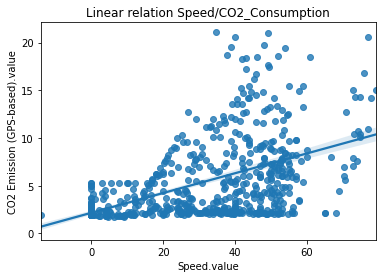

In [9]:
inspect.plot_linear_regression(relation2["Speed.value"], relation2["CO2 Emission (GPS-based).value"], title='Linear relation Speed/CO2_Consumption')

#### Prepare variables

In [10]:
X = np.c_[relation2["Speed.value"]]
y = np.c_[relation2["CO2 Emission (GPS-based).value"]]

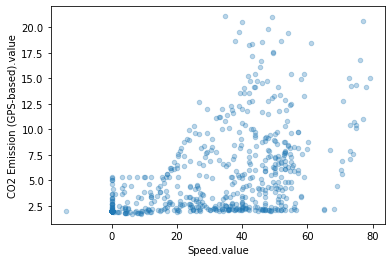

In [11]:
inspect.plot_scatter(relation2,"Speed.value" , "CO2 Emission (GPS-based).value", 0.3)

### Median

Impute nan with median

In [12]:
X_impute= np.c_[relation["CO2 Emission (GPS-based).value"]]
X_impute
imputer=sklearn.impute.SimpleImputer(strategy='median')
imputer.fit(y)

SimpleImputer(strategy='median')

In [13]:
imputedCO2Emission=imputer.transform(X_impute)
imputedCO2Emission

array([[ 2.20006789],
       [ 2.20302462],
       [11.99182982],
       ...,
       [ 3.37204948],
       [ 3.37204948],
       [ 3.37204948]])

### Linear Regression

Impute nan with linear regression model

In [14]:
modelLinear= sklearn.linear_model.LinearRegression()
modelLinear.fit(X, y)
prepareData = np.c_[relation2["Speed.value"]]
y_predicted= modelLinear.predict(prepareData)

#### Check the rmse
We have an rmse of ~ 3.5, this means we have typical prediction error of 3.5

In [15]:
mse = mean_squared_error(y, y_predicted)
rmse = sqrt(mse)
rmse

3.498209231650596

###  K-nearest Neighbor

Impute nan with k-nearest neighbor model

In [16]:
modelNeighbor = sklearn.neighbors.KNeighborsRegressor(n_neighbors=2)
modelNeighbor.fit(X,y)
y_predict_n=modelNeighbor.predict(prepareData)
#y_predict_n

#### Check the rmse
Still not perfect but better: we have here a typical error of ~ 2.4.
We will need more sophisticated methods to impute missing values.

In [17]:
rmse_n = sqrt(mean_squared_error(y, y_predict_n))
rmse_n

2.443151702760583